In [1]:
import matplotlib.pyplot as plt
import numpy as np

from ctapipe.io.lsteventsource import LSTEventSource
from ctapipe.io import EventSeeker        

from calib_drs4 import LSTR1Calibrator, interpolate_spike_A, interpolate_spike_B, get_first_capacitor, int64, ped_time

In [12]:
calib = LSTR1Calibrator(pedestal_path="/media/pawel1/ADATA HD330/20181006/pedestal_00080000.dat")

In [16]:
path_to_data_dir = '/media/pawel1/ADATA HD330/20181006/'
file_path_list = [path_to_data_dir + "LST-1.Run0008.0001.fits.fz"]

size4drs = 4096
roisize = 40
high_gain = 0
low_gain = 1
N_pix = 7

fc_old_array = np.zeros((N_clus, 2, 7))
fc_new_array = np.zeros((N_clus, 2, 7))

last_time_array = np.zeros((N_clus, 2, 7, 4096))

nr_of_events = 15
reader = LSTEventSource(input_url=file_path_list[0])
seeker = EventSeeker(reader)
event = seeker[0:nr_of_events]

N_clus = event[0].lst.tel[0].svc.num_modules

for i, ev in enumerate(event):
    print("event id = ", ev.r0.event_id)  
    calib.calibrate(ev) 
    
    for nr_clus in range(0, N_clus):
        fc_old_array[nr_clus, :, :] = fc_new_array[nr_clus, :, :]
        fc_new_array[nr_clus, :, :] = get_first_capacitor(ev, nr_clus)
        fc_old = fc_old_array[nr_clus, :, :]
        fc_new = fc_new_array[nr_clus, :, :]

        #time lapse correction
        EVB = ev.lst.tel[0].evt.counters
        time_now = int64(EVB[14+(nr_clus*22) : 22+(nr_clus*22)])
        for gain in range(0, 2):
            for pixel in range(0, N_pix):
                for k in range(0, 40):
                    posads = int((k + fc_new[gain, pixel]) % size4drs)
                    if last_time_array[nr_clus, gain, pixel, posads] > 0:
                        time_diff = time_now - last_time_array[nr_clus, gain, pixel, posads]
                        val = ev.r1.tel[0].waveform[gain, pixel + nr_clus*7, k] - ped_time(time_diff/(133.e3))
                        ev.r1.tel[0].waveform[gain, pixel + nr_clus*7, k] = val
                    if (k < 39):
                        last_time_array[nr_clus, gain, pixel, posads] = time_now
                                
                for k in range(0, 4):
                    abspos = int(1024 - roisize-2 - fc_old[gain, pixel]+ k*1024 +size4drs)
                    pos = int((abspos - fc_new[gain, pixel] + size4drs)%size4drs)        
                    if (pos > 2 and pos < 38):
                        interpolate_spike_A(ev, gain, pos, pixel, nr_clus) 
                        
                    abspos = int( roisize-2 + fc_old[gain, pixel]+ k*1024)
                    pos = int((abspos - fc_new[gain, pixel] + size4drs)%size4drs)        
                    if (pos > 2 and pos < 38):        
                        interpolate_spike_A(ev, gain, pos, pixel, nr_clus) 
                    
                spike_b_pos = int((fc_old[gain, pixel] - 1 - fc_new[gain, pixel] + 2*size4drs)%size4drs)
                if spike_b_pos < roisize-1:    
                    interpolate_spike_B(ev, gain, spike_b_pos, pixel, nr_clus)
                
                    

/home/pawel1/anaconda3/envs/cta-dev/lib/python3.6/site-packages/protozfits/__init__.py:56: UserWarning:         Multiple open zfits files at the same time are not supported.
        Reading from mutliple open tables at the same time will reset these
        tables continously and you will read always the same events.
        
  ''')


event id =  6101
event id =  6102
event id =  6103
event id =  6104
event id =  6105
event id =  6106
event id =  6107
event id =  6108
event id =  6109
event id =  6110
event id =  6111
event id =  6112
event id =  6113
event id =  6114
event id =  6115


In [14]:
from plot_drs4_functions import plot_waveform #This is function to plot waveform

event id =  6101


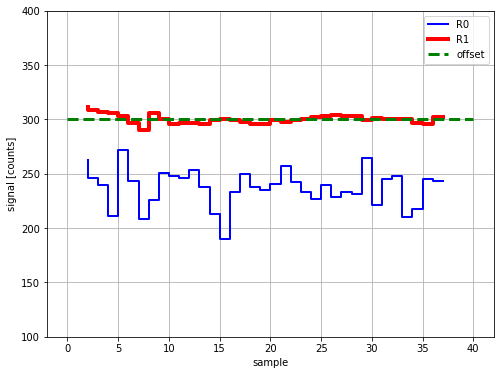

event id =  6102


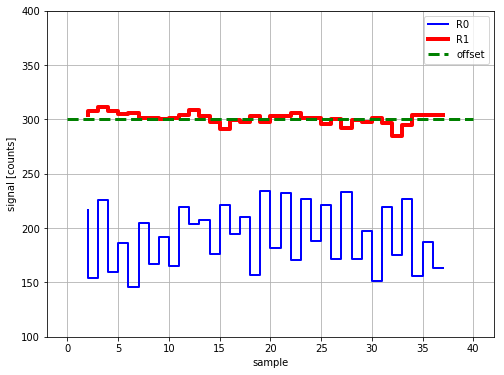

event id =  6103


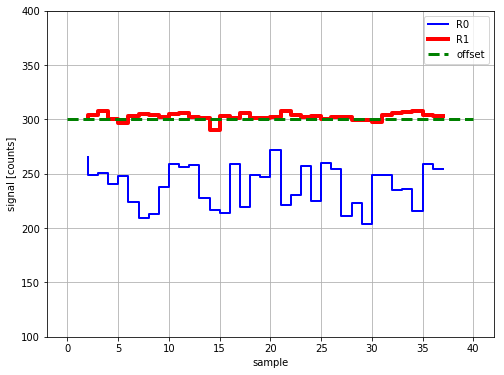

event id =  6104


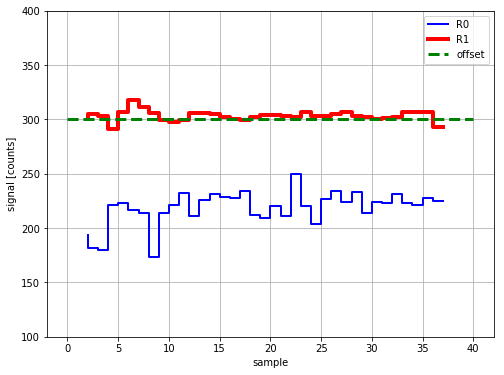

event id =  6105


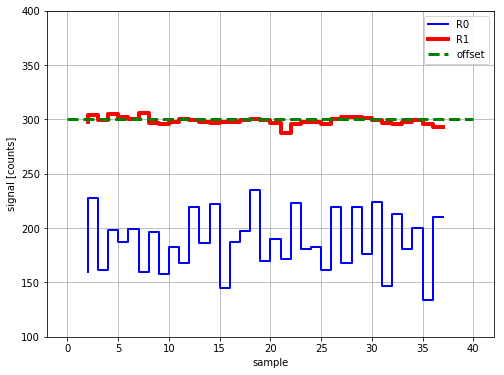

event id =  6106


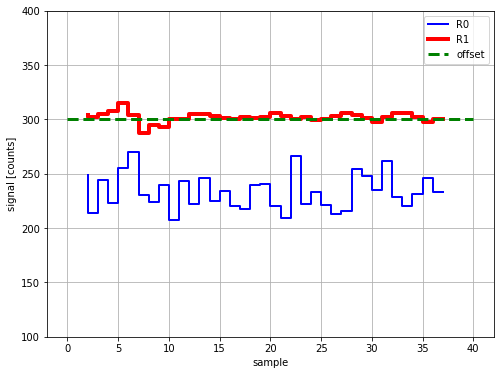

event id =  6107


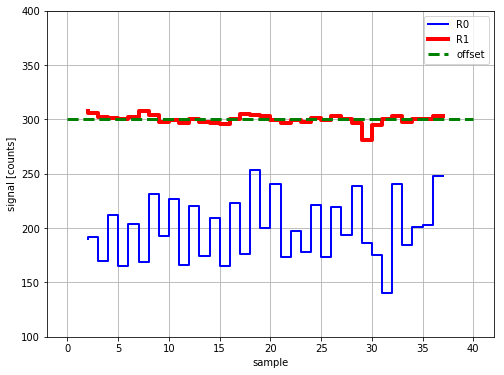

event id =  6108


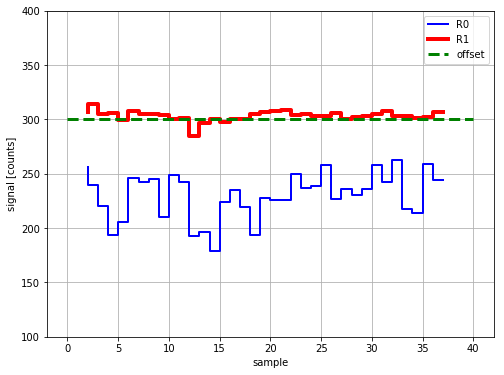

event id =  6109


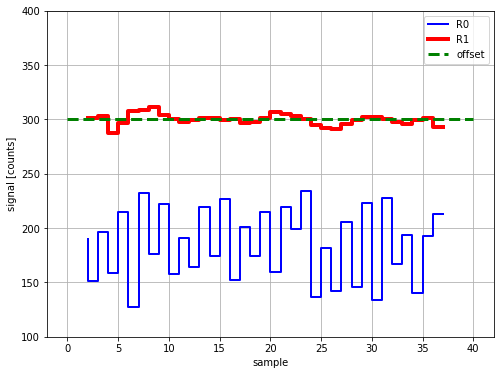

event id =  6110


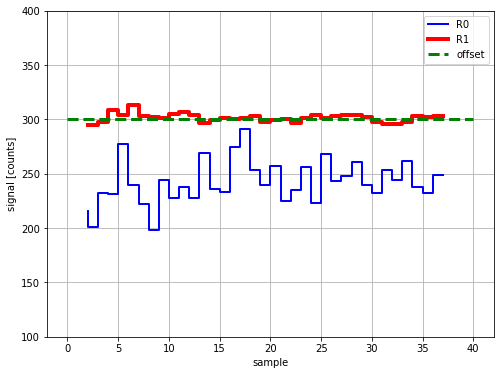

event id =  6111


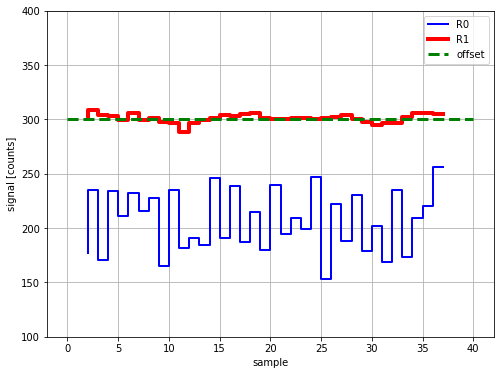

event id =  6112


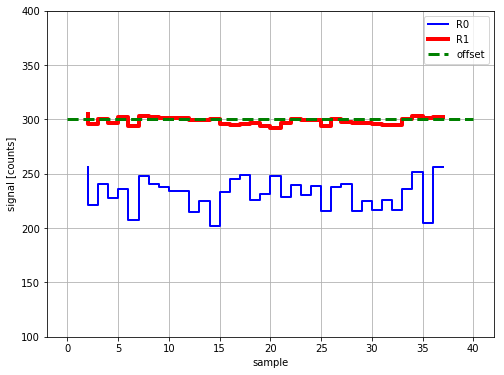

event id =  6113


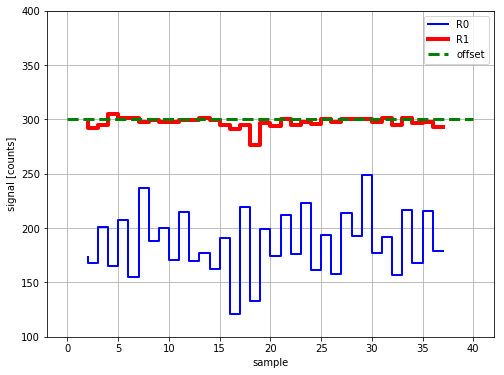

event id =  6114


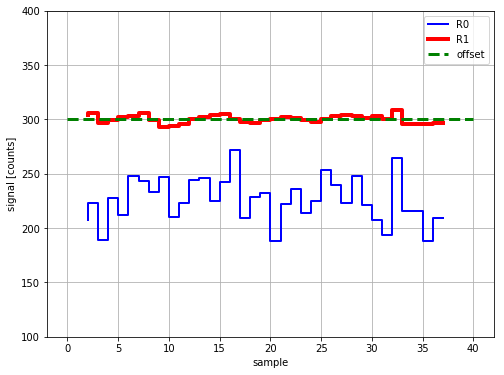

event id =  6115


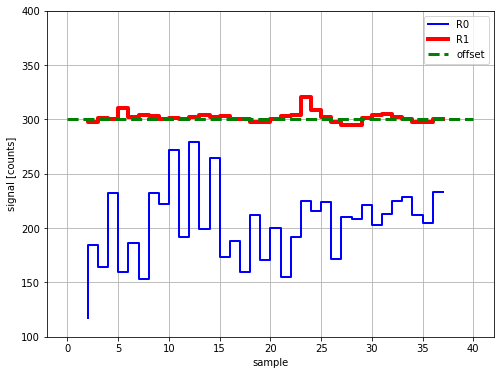

In [17]:
for i, ev in enumerate(event):
    print("event id = ", ev.r0.event_id)  
    plot_waveform(ev, gain=1, nr_clus=200, pixel=0, ylim=[100, 400]) 